Урок 8. Снижение размерности данных

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

In [3]:
X_ = X.astype(float)

rows, cols = X_.shape

means = X_.mean(0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]
        
std = np.std(X_, axis=0)
for i in range(cols):
    for j in range(rows):
        X_[j][i] /= std[i]

In [4]:
covariance_matrix = np.dot(X_.T, X_)

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

In [5]:
eig_pairs.sort(key=lambda x: x[0], reverse=True)

for i in eig_pairs:
    print(i[0])

437.77467247979905
137.1045707202107
22.01353133569719
3.107225464292897


In [6]:
var_exp = [(i/sum(eig_values))*100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [7]:
var_exp

[72.96244541329986, 22.85076178670179, 3.668921889282866, 0.517870910715483]

In [8]:
cum_var_exp

array([ 72.96244541,  95.8132072 ,  99.48212909, 100.        ])

In [9]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

In [10]:
W

array([[ 0.52106591, -0.37741762],
       [-0.26934744, -0.92329566],
       [ 0.5804131 , -0.02449161],
       [ 0.56485654, -0.06694199]])

In [11]:
Z = X_.dot(W)

In [12]:
X_[:5]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

In [13]:
Z[:5]

array([[-2.26470281, -0.4800266 ],
       [-2.08096115,  0.67413356],
       [-2.36422905,  0.34190802],
       [-2.29938422,  0.59739451],
       [-2.38984217, -0.64683538]])

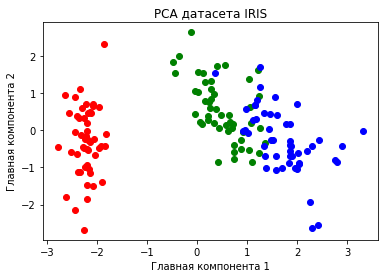

In [14]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

Таким образом, мы перешли от четырехмерного пространства признаков к двумерному и при этом классы остались разделимы в пространстве, то есть классификация возможна.

PCA наиболее хорошо работает, когда собственные значения λ  на каком-то участке графика распределения убывают скачкообразно (критерий крутого склона), другими словами, если существуют предпосылки к тому, что следует решать задачу в пространстве меньшей размерности. Если же они убывают монотонно, следует рассмотреть вариант использования других методов работы с пространством признаков.

Для самостоятельной работы

Можно ли отобрать наиболее значимые признаки с помощью PCA?

Нет, с помощью PCA можно уменьшить размерность данных (сократить кол-во признаков). Для отбора наиболее значимых признаков следует использовать другие методы, например: feature_importance (Tree / RandomForest), коэф-ты регресии с L1-регуляризацией.

Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd()

In [15]:
class CustomPCA:
    
    def __init__(self, n_components=None):
        self.__n_components = n_components
    
    def __get_n_components(self, X):
        n = self.__n_components
        if n == None:
            n == X.shape[1]
        return n
    
    def __set_exp_var(self, exp_var):
        self.exp_var_ = exp_var
        
    def __set_cum_exp_var(self, cum_exp_var):
        self.cum_exp_var_ = cum_exp_var
    
    def fit_transform(self, X):
        n = self.__get_n_components(X)
        U, s, Vt = np.linalg.svd(X, full_matrices=False)
        V = Vt.T
        S = np.diag(s)
        exp_var = np.round(s**2/np.sum(s**2), decimals=4)[:n]
        cum_exp_var = np.cumsum(exp_var)
        self.__set_exp_var(exp_var)
        self.__set_cum_exp_var(cum_exp_var)
        X_transformed = U[:, 0:n].dot(S[0:n, 0:n])
        return X_transformed

In [16]:
custom_pca = CustomPCA(2)
Z = custom_pca.fit_transform(X_)

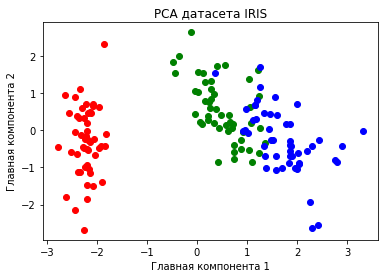

In [17]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

Обучить любую модель классификации на датасете iris до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction_classification = self.predict()
        self.prediction_regression = self.predict_reg()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

    def predict_reg(self):
        #  найдем значение как среднее по выборке   
        prediction = np.mean(self.labels)
        return prediction
    
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# Расчет качества для задачи классификации
def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения для задачи классификации
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# Построение дерева классификации с помощью рекурсивной функции
def build_tree_classification(data, labels, tree_depth=1, max_depth=50):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    # Базовый случай (2) - прекращаем рекурсию, когда достигнута максимальная глубина дерева
    if tree_depth >= max_depth:
        return Leaf(data, labels)

    # Увеличиваем глубину дерева на 1
    tree_depth += 1

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_classification(true_data, true_labels, tree_depth, max_depth)
    false_branch = build_tree_classification(false_data, false_labels, tree_depth, max_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction_classification
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
def predict_class(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y)

In [20]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
custom_tree = build_tree_classification(X_train, y_train, max_depth=3)

y_train_pred = predict_class(X_train, custom_tree)
y_test_pred = predict_class(X_test, custom_tree)

print(f'Accuracy score (original train data): {np.round(accuracy(y_train, y_train_pred), 4)}')
print(f'Accuracy score (original test data): {np.round(accuracy(y_test, y_test_pred), 4)}')

Accuracy score (original train data): 0.7733
Accuracy score (original test data): 0.1867


In [23]:
custom_pca = CustomPCA(n_components=3)

X_pca = custom_pca.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
custom_tree = build_tree_classification(X_train, y_train, max_depth=3)

y_train_pred = predict_class(X_train, custom_tree)
y_test_pred = predict_class(X_test, custom_tree)

print(f'Accuracy score (pca train data): {np.round(accuracy(y_train, y_train_pred), 4)}')
print(f'Accuracy score (pca test data): {np.round(accuracy(y_test, y_test_pred), 4)}')

Accuracy score (pca train data): 0.78
Accuracy score (pca test data): 0.1933
